In [1]:
import torch
from torch import nn
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import torchvision
import torchvision.datasets

In [4]:
means = (0.4914, 0.4822, 0.4465)
stds = (0.2023, 0.1994, 0.2010)

In [5]:
batch_size = 64

transform =  torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(means, stds, inplace=True)])

train_dataset = torchvision.datasets.CIFAR10(
    root = os.getcwd(), train = True, download = True,
    transform = transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root = os.getcwd(), train = False, download = True,
    transform = transform
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
expected_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = train_dataset.classes
num_classes = len(class_names)
assert(num_classes==10)
assert(class_names==expected_class_names)
print(''.join(f'{name}'.rjust(10, ' ') + f': {index}\n' for index, name in enumerate(class_names)))

  airplane: 0
automobile: 1
      bird: 2
       cat: 3
      deer: 4
       dog: 5
      frog: 6
     horse: 7
      ship: 8
     truck: 9



In [7]:
assert train_dataset.data.shape == (50000, 32, 32, 3)
assert test_dataset.data.shape == (10000, 32, 32, 3)

In [8]:
means = torch.tensor(means).reshape(3, 1, 1)
stds = torch.tensor(stds).reshape(3, 1, 1)

def image_to_showable(image):
  img = image * stds + means
  img = img.numpy().transpose(1, 2, 0)
  return (img*255).astype('uint8')

In [9]:
def show_dataset(dataset, title):
  print(f'{title} : {len(dataset)}')
  num_rows, num_col = 5, 5
  fig, axes = plt.subplots(num_rows, num_col, figsize = (12, 12))
  fig.suptitle(title, fontsize=32)
  for i, ax in enumerate(axes.flat):
    img = image_to_showable(dataset[i][0])
    ax.text(0.1, 0.9, f'{class_names[dataset[i][1]]}', size=15, color='purple')
    ax.imshow(img)

Train samples : 50000


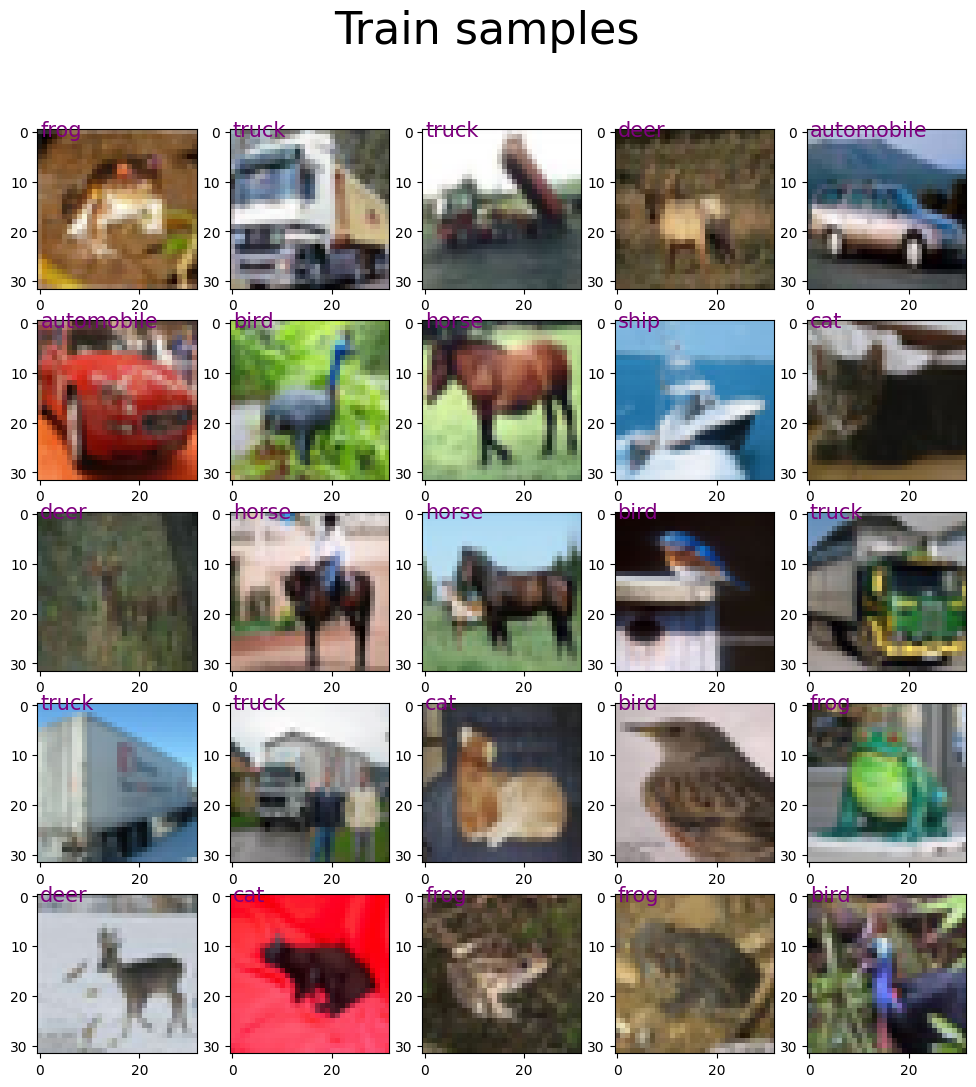

In [10]:
show_dataset(train_dataset, "Train samples")

Test samples : 10000


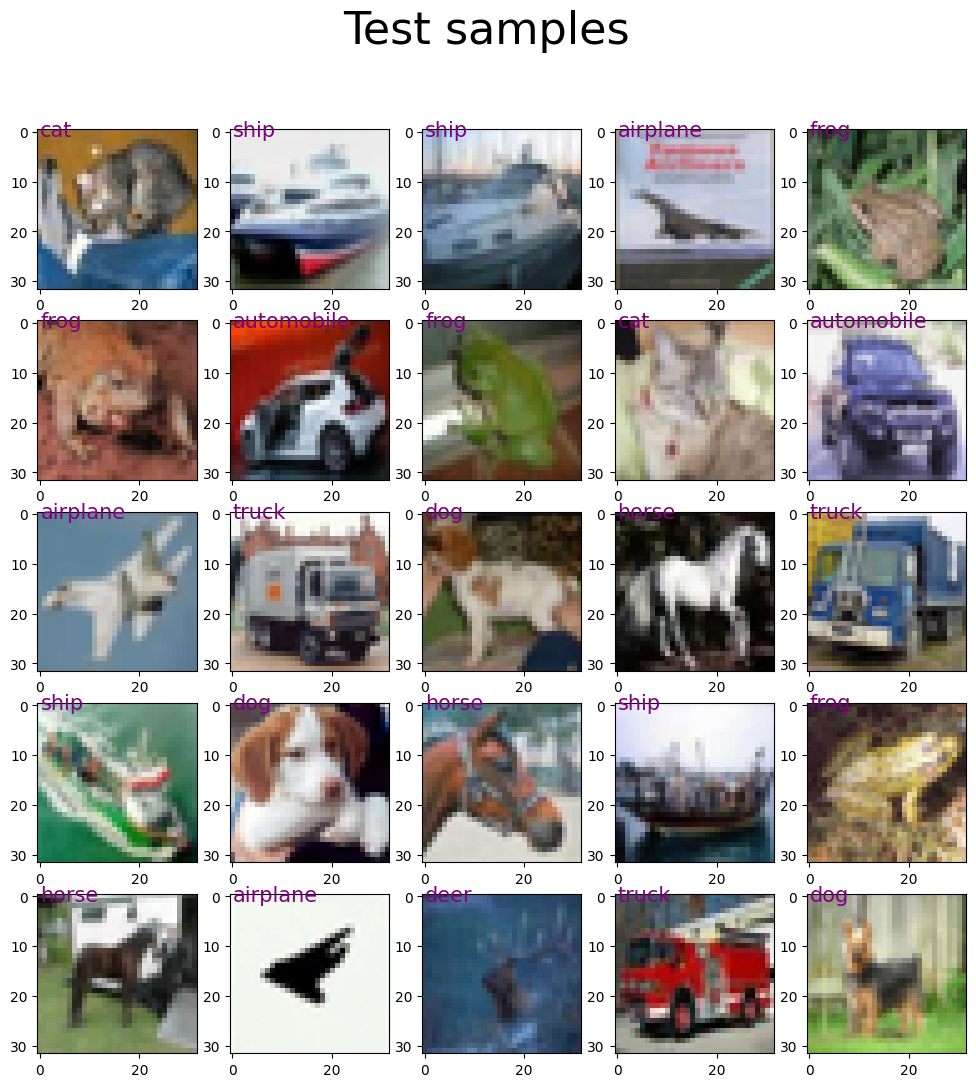

In [11]:
show_dataset(test_dataset, "Test samples")

In [12]:
def show_single_image(image, title):
  img = image_to_showable(image)
  plt.title(title)
  plt.imshow(img)

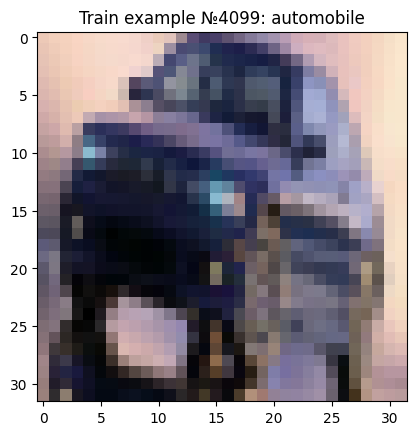

In [13]:
my_random_number = 4099 # я честно запустил рандом и получил это число. значит оно случайное))))
sample = train_dataset[my_random_number]
show_single_image(sample[0], f'Train example №{my_random_number}: {class_names[sample[1]]}')

## Архитектура

In [14]:
vgg11 = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg13 = [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]
vgg19 = [64, 64,'M', 128, 128,'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512,'M',512, 512, 512, 512,'M']

In [15]:
class VGGNet(nn.Module):
  def __init__(self, config_list):
    super(VGGNet, self).__init__()
    self.config_list = config_list
    self.layers = self.build_features()
    self.classifier = self.build_classifier()

  def build_features(self):
    layers = []
    in_channels = 3
    for layer in self.config_list:
      if layer=='M':
        layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
      else:
        layers.append(nn.Conv2d(in_channels = in_channels, out_channels = layer,
                          kernel_size = 3, stride = 1, padding = 1))
        layers.append(nn.BatchNorm2d(layer))
        layers.append(nn.ReLU())
        in_channels = layer
    return nn.Sequential(*layers)

  def build_classifier(self):
    layers = []
    layers.append(nn.Flatten())
    layers.append(nn.Linear(512, 1024))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Dropout(0.3)),
    layers.append(nn.Linear(1024, 1024))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Dropout(0.3)),
    layers.append(nn.Linear(1024, num_classes))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.layers(x)
    x = self.classifier(x)
    return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VGGNet(vgg19)
model.to(device)

VGGNet(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

%pip install torchview

'''оно работало в colab...'''
import graphviz
from torchview import draw_graph
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [17]:
@torch.no_grad()
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n += labels.size(0)
        tp += (predicted == labels).sum()
    return tp / n

@torch.no_grad()
def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        loss += loss_function(outputs, labels)
        n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

In [18]:
def train(model, data_loader, num_epochs, loss_function, optimizer, device):
  train_acc, test_acc = [], []
  start_time = time.time()
  for epoch in range(1, num_epochs+1):
    start_epoch = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    curr_train_acc = torch.stack(accuracies).mean()
    train_acc.append(curr_train_acc)
    test_acc.append(get_accuracy(model, test_data_loader, device).cpu())
    print(f"Epoch '({epoch}): Loss = {torch.stack(losses).mean():.4f}, Train accuracy = {curr_train_acc:.4f}, Time epoch = {time.time() - start_epoch:.4f}")
  print(f'Total time {time.time() - start_time}')
  return (train_acc, test_acc)

In [19]:
learning_rate = 0.001
num_epochs = 27

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, amsgrad = True, weight_decay = 0.0001)

In [20]:
history = train(model, train_data_loader, num_epochs, loss_function, optimizer, device)

Epoch '(1): Loss = 1.8726, Train accuracy = 0.2290, Time epoch = 40.3702
Epoch '(2): Loss = 1.5585, Train accuracy = 0.3687, Time epoch = 38.2154
Epoch '(3): Loss = 1.3114, Train accuracy = 0.5162, Time epoch = 38.2175
Epoch '(4): Loss = 1.0653, Train accuracy = 0.6285, Time epoch = 38.3729
Epoch '(5): Loss = 0.9223, Train accuracy = 0.6830, Time epoch = 37.9652
Epoch '(6): Loss = 0.8120, Train accuracy = 0.7229, Time epoch = 36.5798
Epoch '(7): Loss = 0.7269, Train accuracy = 0.7571, Time epoch = 36.0028
Epoch '(8): Loss = 0.6477, Train accuracy = 0.7877, Time epoch = 38.8933
Epoch '(9): Loss = 0.5728, Train accuracy = 0.8168, Time epoch = 38.0834
Epoch '(10): Loss = 0.5113, Train accuracy = 0.8396, Time epoch = 40.1933
Epoch '(11): Loss = 0.4715, Train accuracy = 0.8515, Time epoch = 40.0169
Epoch '(12): Loss = 0.4267, Train accuracy = 0.8654, Time epoch = 39.0996
Epoch '(13): Loss = 0.3916, Train accuracy = 0.8779, Time epoch = 38.3173
Epoch '(14): Loss = 0.3476, Train accuracy = 0.

In [21]:
print(f'Loss = {get_loss(model, test_data_loader, device):.4f},'+
      f'Test accuracy = {get_accuracy(model, test_data_loader, device):.4f}')

Loss = 0.0100,Test accuracy = 0.8402


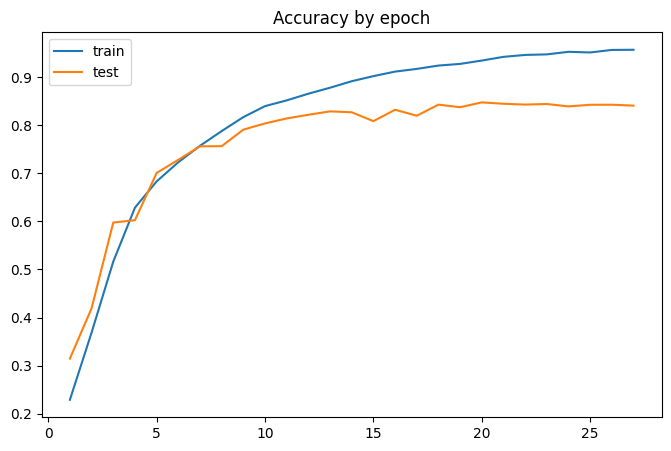

In [22]:
def plot_history(history):
  train_acc, test_acc = history
  x = list(range(1, num_epochs+1))
  plt.figure(figsize=(8,5))
  plt.plot(x, train_acc, label='train')
  plt.plot(x, test_acc, label='test')
  plt.title('Accuracy by epoch')
  plt.legend()
plot_history(history)